# 🔬 Análise Exploratória - Dataset de Pneumonia

Neste notebook, vamos explorar o dataset de raios-X de tórax para entender melhor os dados antes de treinar nossos modelos de deep learning.

## 📋 Objetivos:
1. Carregar e visualizar o dataset
2. Analisar a distribuição das classes
3. Explorar características das imagens
4. Identificar possíveis desafios
5. Preparar estratégia de pré-processamento

---

## 📚 1. Importar Bibliotecas

In [4]:
# Manipulação de dados
import numpy as np
import pandas as pd
from pathlib import Path

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Utilities
import os
import random
from collections import Counter

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 📂 2. Definir Caminhos e Verificar Estrutura

In [5]:
# Definir caminho base
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data' / 'chest_xray'

# Verificar se o dataset existe
if not DATA_DIR.exists():
    print("❌ Dataset não encontrado!")
    print(f"   Caminho esperado: {DATA_DIR}")
    print("\n💡 Execute o script de download primeiro:")
    print("   python ../src/download_dataset.py")
else:
    print("✅ Dataset encontrado!")
    print(f"📁 Localização: {DATA_DIR}\n")
    
    # Listar estrutura
    print("📊 Estrutura do dataset:")
    for split in ['train', 'test', 'val']:
        split_path = DATA_DIR / split
        if split_path.exists():
            print(f"\n{split.upper()}/")
            for category in ['NORMAL', 'PNEUMONIA']:
                cat_path = split_path / category
                if cat_path.exists():
                    count = len(list(cat_path.glob('*.jpeg'))) + len(list(cat_path.glob('*.jpg')))
                    print(f"  ├── {category}/  ({count} imagens)")

✅ Dataset encontrado!
📁 Localização: ..\data\chest_xray

📊 Estrutura do dataset:

TRAIN/
  ├── NORMAL/  (1341 imagens)
  ├── PNEUMONIA/  (3875 imagens)

TEST/
  ├── NORMAL/  (234 imagens)
  ├── PNEUMONIA/  (390 imagens)

VAL/
  ├── NORMAL/  (8 imagens)
  ├── PNEUMONIA/  (8 imagens)


## 📊 3. Análise da Distribuição dos Dados

In [6]:
def count_images_per_class(data_dir):
    """Conta imagens por classe e split."""
    results = {}
    
    for split in ['train', 'test', 'val']:
        split_path = data_dir / split
        if not split_path.exists():
            continue
            
        results[split] = {}
        for category in ['NORMAL', 'PNEUMONIA']:
            cat_path = split_path / category
            if cat_path.exists():
                count = len(list(cat_path.glob('*.jpeg'))) + len(list(cat_path.glob('*.jpg')))
                results[split][category] = count
    
    return results

# Contar imagens
image_counts = count_images_per_class(DATA_DIR)

# Criar DataFrame para visualização
data_for_df = []
for split, classes in image_counts.items():
    for class_name, count in classes.items():
        data_for_df.append({
            'Split': split.upper(),
            'Classe': class_name,
            'Quantidade': count
        })

df_counts = pd.DataFrame(data_for_df)

print("📊 Distribuição do Dataset:")
print("="*60)
print(df_counts.to_string(index=False))
print("="*60)

# Calcular totais
print("\n📈 Resumo por Split:")
for split in ['train', 'test', 'val']:
    split_upper = split.upper()
    split_data = df_counts[df_counts['Split'] == split_upper]
    total = split_data['Quantidade'].sum()
    normal = split_data[split_data['Classe'] == 'NORMAL']['Quantidade'].values[0]
    pneumonia = split_data[split_data['Classe'] == 'PNEUMONIA']['Quantidade'].values[0]
    
    print(f"\n{split_upper}:")
    print(f"  Total: {total} imagens")
    print(f"  NORMAL: {normal} ({normal/total*100:.1f}%)")
    print(f"  PNEUMONIA: {pneumonia} ({pneumonia/total*100:.1f}%)")
    print(f"  Razão PNEUMONIA/NORMAL: {pneumonia/normal:.2f}")

📊 Distribuição do Dataset:
Split    Classe  Quantidade
TRAIN    NORMAL        1341
TRAIN PNEUMONIA        3875
 TEST    NORMAL         234
 TEST PNEUMONIA         390
  VAL    NORMAL           8
  VAL PNEUMONIA           8

📈 Resumo por Split:

TRAIN:
  Total: 5216 imagens
  NORMAL: 1341 (25.7%)
  PNEUMONIA: 3875 (74.3%)
  Razão PNEUMONIA/NORMAL: 2.89

TEST:
  Total: 624 imagens
  NORMAL: 234 (37.5%)
  PNEUMONIA: 390 (62.5%)
  Razão PNEUMONIA/NORMAL: 1.67

VAL:
  Total: 16 imagens
  NORMAL: 8 (50.0%)
  PNEUMONIA: 8 (50.0%)
  Razão PNEUMONIA/NORMAL: 1.00


### 📊 Visualizar Distribuição

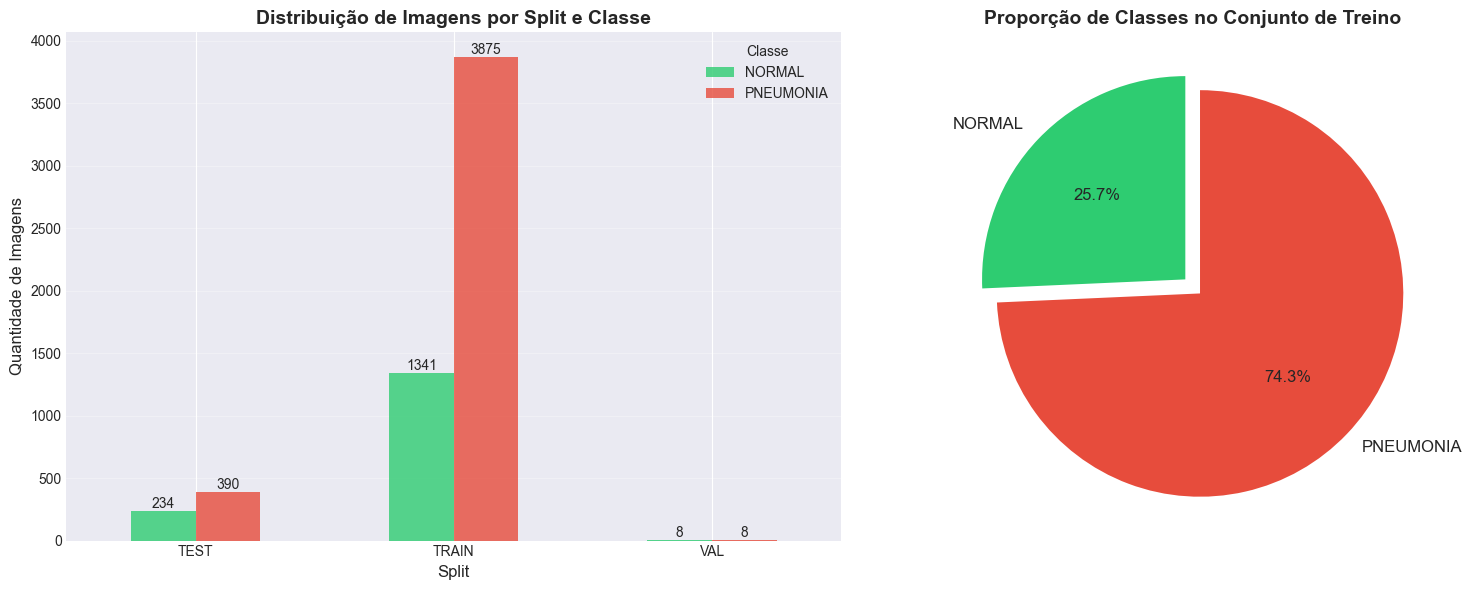


⚠️ OBSERVAÇÃO IMPORTANTE:
   O dataset está DESBALANCEADO - há mais imagens de PNEUMONIA que NORMAL.
   Isso é esperado em datasets médicos, mas precisaremos lidar com isso!


In [7]:
# Gráfico de barras agrupadas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação por Split
df_pivot = df_counts.pivot(index='Split', columns='Classe', values='Quantidade')
df_pivot.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[0].set_title('Distribuição de Imagens por Split e Classe', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Split', fontsize=12)
axes[0].set_ylabel('Quantidade de Imagens', fontsize=12)
axes[0].legend(title='Classe', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

# Adicionar valores nas barras
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=10)

# Gráfico 2: Proporção de classes no conjunto de treino
train_data = df_counts[df_counts['Split'] == 'TRAIN']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[1].pie(train_data['Quantidade'], labels=train_data['Classe'], autopct='%1.1f%%',
           colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Proporção de Classes no Conjunto de Treino', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ OBSERVAÇÃO IMPORTANTE:")
print("   O dataset está DESBALANCEADO - há mais imagens de PNEUMONIA que NORMAL.")
print("   Isso é esperado em datasets médicos, mas precisaremos lidar com isso!")

## 🖼️ 4. Visualizar Amostras de Imagens

🖼️ Visualizando amostras de cada classe...



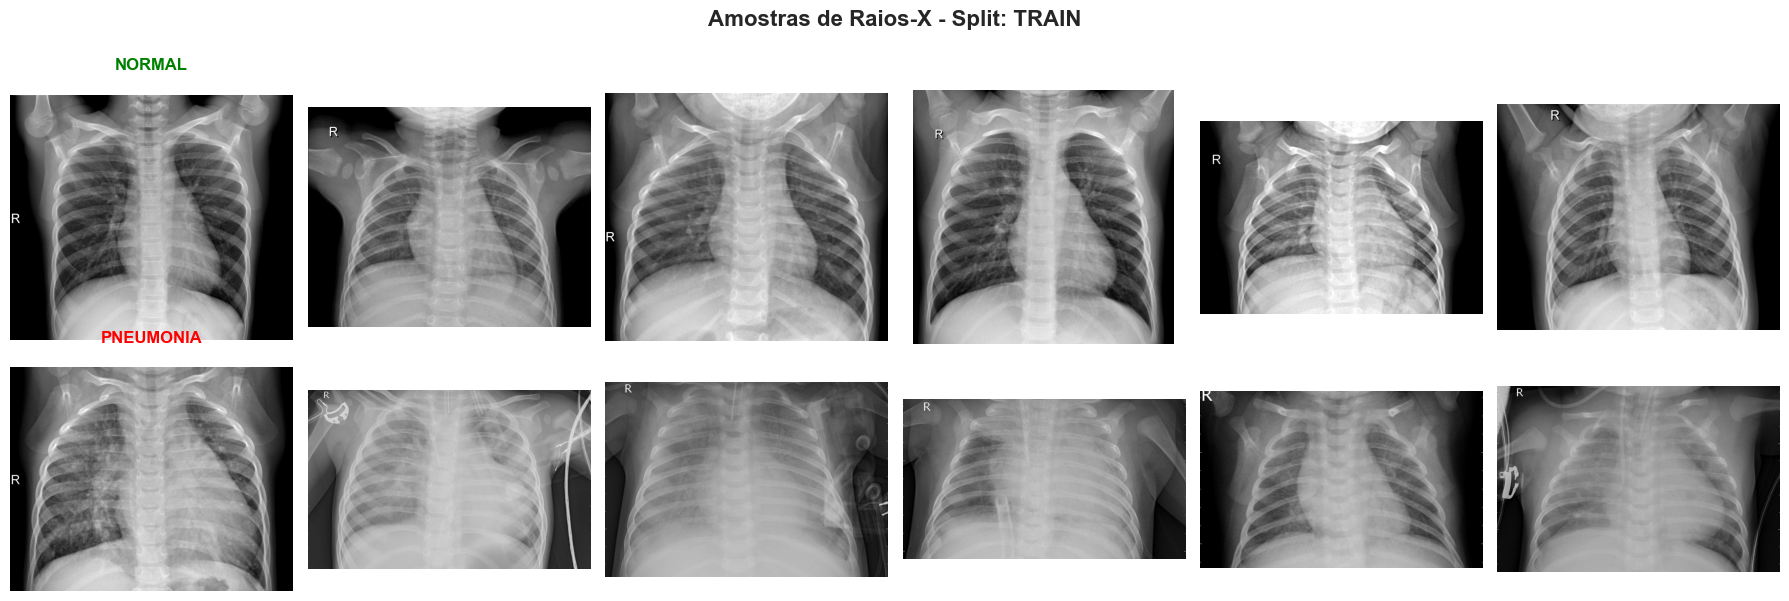

In [8]:
def plot_sample_images(data_dir, split='train', samples_per_class=6):
    """Plota amostras de imagens de cada classe."""
    
    fig, axes = plt.subplots(2, samples_per_class, figsize=(18, 6))
    
    for idx, category in enumerate(['NORMAL', 'PNEUMONIA']):
        cat_path = data_dir / split / category
        images = list(cat_path.glob('*.jpeg'))
        
        # Selecionar amostras aleatórias
        samples = random.sample(images, min(samples_per_class, len(images)))
        
        for col, img_path in enumerate(samples):
            img = Image.open(img_path)
            axes[idx, col].imshow(img, cmap='gray')
            axes[idx, col].axis('off')
            
            if col == 0:
                axes[idx, col].set_title(f'{category}\n', 
                                        fontsize=12, fontweight='bold',
                                        color='green' if category == 'NORMAL' else 'red')
    
    fig.suptitle(f'Amostras de Raios-X - Split: {split.upper()}', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Plotar amostras
print("🖼️ Visualizando amostras de cada classe...\n")
plot_sample_images(DATA_DIR, split='train', samples_per_class=6)

## 📏 5. Analisar Dimensões das Imagens

In [9]:
def analyze_image_dimensions(data_dir, split='train', sample_size=100):
    """Analisa dimensões das imagens."""
    
    dimensions = {'NORMAL': [], 'PNEUMONIA': []}
    
    for category in ['NORMAL', 'PNEUMONIA']:
        cat_path = data_dir / split / category
        images = list(cat_path.glob('*.jpeg'))
        
        # Amostrar imagens
        samples = random.sample(images, min(sample_size, len(images)))
        
        for img_path in samples:
            img = Image.open(img_path)
            dimensions[category].append(img.size)  # (width, height)
    
    return dimensions

# Analisar dimensões
print("📏 Analisando dimensões das imagens (amostra de 100 por classe)...\n")
dims = analyze_image_dimensions(DATA_DIR, split='train', sample_size=100)

# Estatísticas
for category in ['NORMAL', 'PNEUMONIA']:
    widths = [d[0] for d in dims[category]]
    heights = [d[1] for d in dims[category]]
    
    print(f"{category}:")
    print(f"  Largura  - Média: {np.mean(widths):.0f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
    print(f"  Altura   - Média: {np.mean(heights):.0f}, Min: {np.min(heights)}, Max: {np.max(heights)}")
    print(f"  Aspectos únicos: {len(set(dims[category]))}\n")

📏 Analisando dimensões das imagens (amostra de 100 por classe)...

NORMAL:
  Largura  - Média: 1691, Min: 1120, Max: 2619
  Altura   - Média: 1425, Min: 885, Max: 2628
  Aspectos únicos: 100

PNEUMONIA:
  Largura  - Média: 1216, Min: 445, Max: 2050
  Altura   - Média: 862, Min: 140, Max: 1992
  Aspectos únicos: 100

NORMAL:
  Largura  - Média: 1691, Min: 1120, Max: 2619
  Altura   - Média: 1425, Min: 885, Max: 2628
  Aspectos únicos: 100

PNEUMONIA:
  Largura  - Média: 1216, Min: 445, Max: 2050
  Altura   - Média: 862, Min: 140, Max: 1992
  Aspectos únicos: 100



### 📊 Visualizar Distribuição de Dimensões

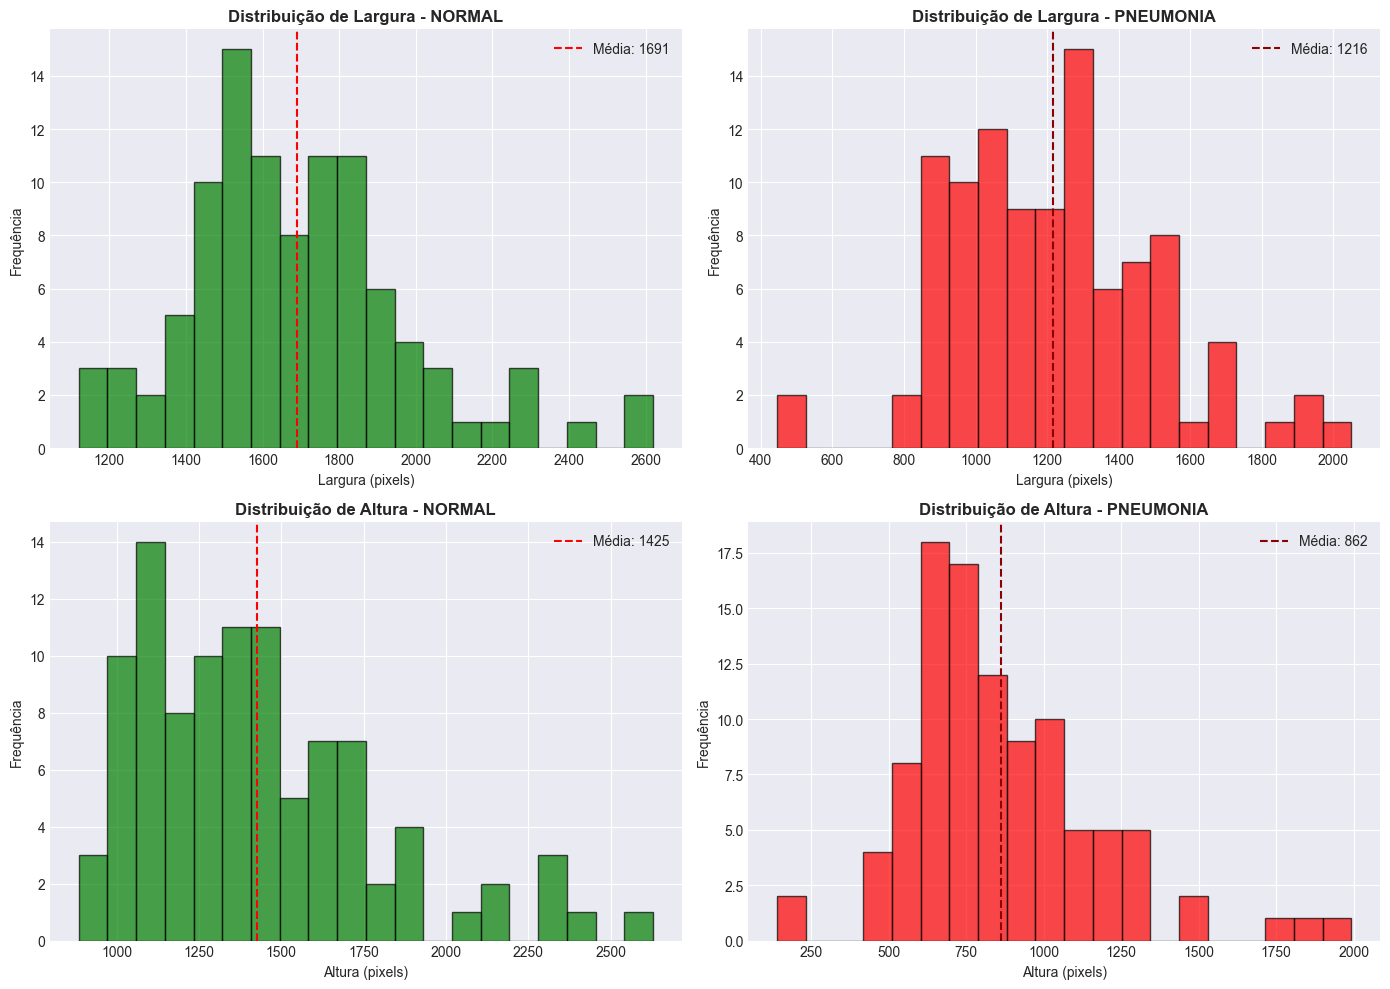


💡 Conclusão:
   As imagens têm dimensões variadas. Precisaremos redimensioná-las
   para um tamanho fixo (ex: 224x224) para treinar as CNNs.


In [10]:
# Preparar dados para plotagem
widths_normal = [d[0] for d in dims['NORMAL']]
heights_normal = [d[1] for d in dims['NORMAL']]
widths_pneum = [d[0] for d in dims['PNEUMONIA']]
heights_pneum = [d[1] for d in dims['PNEUMONIA']]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Largura - NORMAL
axes[0, 0].hist(widths_normal, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribuição de Largura - NORMAL', fontweight='bold')
axes[0, 0].set_xlabel('Largura (pixels)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(np.mean(widths_normal), color='red', linestyle='--', 
                   label=f'Média: {np.mean(widths_normal):.0f}')
axes[0, 0].legend()

# Largura - PNEUMONIA
axes[0, 1].hist(widths_pneum, bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribuição de Largura - PNEUMONIA', fontweight='bold')
axes[0, 1].set_xlabel('Largura (pixels)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(np.mean(widths_pneum), color='darkred', linestyle='--',
                   label=f'Média: {np.mean(widths_pneum):.0f}')
axes[0, 1].legend()

# Altura - NORMAL
axes[1, 0].hist(heights_normal, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribuição de Altura - NORMAL', fontweight='bold')
axes[1, 0].set_xlabel('Altura (pixels)')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].axvline(np.mean(heights_normal), color='red', linestyle='--',
                   label=f'Média: {np.mean(heights_normal):.0f}')
axes[1, 0].legend()

# Altura - PNEUMONIA
axes[1, 1].hist(heights_pneum, bins=20, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribuição de Altura - PNEUMONIA', fontweight='bold')
axes[1, 1].set_xlabel('Altura (pixels)')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].axvline(np.mean(heights_pneum), color='darkred', linestyle='--',
                   label=f'Média: {np.mean(heights_pneum):.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Conclusão:")
print("   As imagens têm dimensões variadas. Precisaremos redimensioná-las")
print("   para um tamanho fixo (ex: 224x224) para treinar as CNNs.")

## 🎨 6. Analisar Intensidade dos Pixels

🎨 Analisando intensidade de pixels (amostra de 20 imagens por classe)...



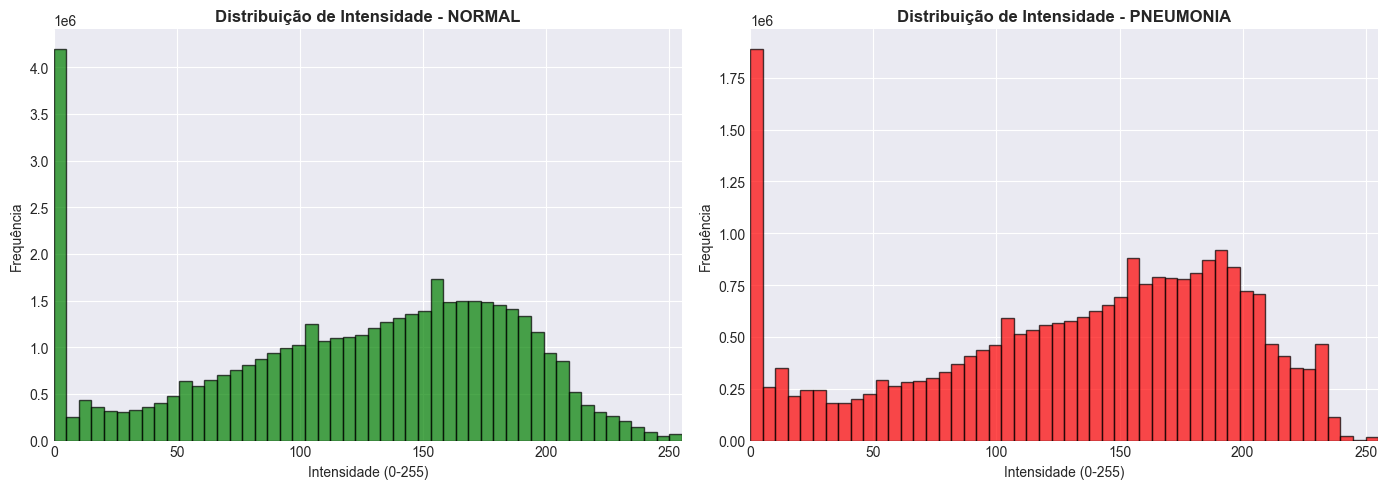


NORMAL - Intensidade média: 121.34
PNEUMONIA - Intensidade média: 130.34


In [11]:
def analyze_pixel_intensity(data_dir, split='train', sample_size=20):
    """Analisa distribuição de intensidade dos pixels."""
    
    intensities = {'NORMAL': [], 'PNEUMONIA': []}
    
    for category in ['NORMAL', 'PNEUMONIA']:
        cat_path = data_dir / split / category
        images = list(cat_path.glob('*.jpeg'))
        samples = random.sample(images, min(sample_size, len(images)))
        
        for img_path in samples:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            intensities[category].extend(img.flatten())
    
    return intensities

# Analisar intensidades
print("🎨 Analisando intensidade de pixels (amostra de 20 imagens por classe)...\n")
intensities = analyze_pixel_intensity(DATA_DIR, split='train', sample_size=20)

# Plotar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(intensities['NORMAL'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribuição de Intensidade - NORMAL', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Intensidade (0-255)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlim([0, 255])

axes[1].hist(intensities['PNEUMONIA'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribuição de Intensidade - PNEUMONIA', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Intensidade (0-255)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlim([0, 255])

plt.tight_layout()
plt.show()

print(f"\nNORMAL - Intensidade média: {np.mean(intensities['NORMAL']):.2f}")
print(f"PNEUMONIA - Intensidade média: {np.mean(intensities['PNEUMONIA']):.2f}")

## 📝 7. Conclusões e Próximos Passos

### 🔍 O que descobrimos:

1. **Desbalanceamento**: 
   - O dataset tem mais imagens de PNEUMONIA que NORMAL
   - Precisaremos usar técnicas como class weights ou data augmentation

2. **Dimensões variadas**:
   - As imagens têm tamanhos diferentes
   - Vamos redimensionar para 224x224 (padrão para modelos pré-treinados)

3. **Qualidade das imagens**:
   - Raios-X em escala de cinza
   - Boa qualidade geral, mas com variação

### 🎯 Estratégias de pré-processamento:

- ✅ **Redimensionamento**: 224x224 pixels
- ✅ **Normalização**: Dividir por 255 (valores entre 0 e 1)
- ✅ **Data Augmentation**: Rotação, zoom, flip para aumentar variedade
- ✅ **Class Weights**: Penalizar mais erros na classe minoritária
- ✅ **Transfer Learning**: Usar modelos pré-treinados (VGG16, ResNet50)

### 🚀 Próximas etapas:

1. Criar pipeline de pré-processamento
2. Implementar arquiteturas CNN
3. Treinar múltiplos modelos
4. Avaliar e comparar resultados
5. Interpretar decisões do modelo

---
